In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
from scipy import linalg
from scipy import signal
from scipy.signal import butter, filtfilt
from scipy.linalg import eig
from noControl import matrix, TransferFunc, AR_model

In [2]:
def print_structure(name, obj):
    obj_type = "Group" if isinstance(obj, h5py.Group) else "Dataset"
    info = f" | shape: {obj.shape} | dtype: {obj.dtype}" if isinstance(obj, h5py.Dataset) else ""
    print(f"{obj_type}: {name}{info}")

with h5py.File('SaSR_test.hdf5', 'r') as f:
    f.visititems(print_structure)


Group: SR
Dataset: SR/V1:ENV_CEB_SEIS_V | shape: (1800000,) | dtype: float32
Dataset: SR/V1:ENV_CEB_SEIS_V_dec | shape: (112500,) | dtype: float32
Dataset: SR/V1:Sa_SR_F0_LVDT_V_500Hz | shape: (900000,) | dtype: float32
Dataset: SR/V1:Sa_SR_F0_LVDT_V_500Hz_dec | shape: (112500,) | dtype: float32
Dataset: SR/V1:Sa_SR_F1_LVDT_V_500Hz | shape: (900000,) | dtype: float32
Dataset: SR/V1:Sa_SR_F1_LVDT_V_500Hz_dec | shape: (112500,) | dtype: float32
Dataset: SR/V1:Sa_SR_F2_LVDT_V_500Hz | shape: (900000,) | dtype: float32
Dataset: SR/V1:Sa_SR_F2_LVDT_V_500Hz_dec | shape: (112500,) | dtype: float32
Dataset: SR/V1:Sa_SR_F3_LVDT_V_500Hz | shape: (900000,) | dtype: float32
Dataset: SR/V1:Sa_SR_F3_LVDT_V_500Hz_dec | shape: (112500,) | dtype: float32
Dataset: SR/V1:Sa_SR_F4_LVDT_V_500Hz | shape: (900000,) | dtype: float32
Dataset: SR/V1:Sa_SR_F4_LVDT_V_500Hz_dec | shape: (112500,) | dtype: float32
Dataset: SR/V1:Sa_SR_F7_LVDT_V_500Hz | shape: (900000,) | dtype: float32
Dataset: SR/V1:Sa_SR_F7_LVDT_V

In [3]:
with h5py.File('SaSR_test.hdf5', 'r') as f:
    dset = f['SR/V1:ENV_CEB_SEIS_V_dec']
    for key, value in dset.attrs.items():
        print(f"{key}: {value}")

channel: V1:ENV_CEB_SEIS_V_dec
sample_rate: 62.5
t0: 1431561618.0
units: m.s-1


In [5]:
f = h5py.File('SaSR_test.hdf5', 'r')
seism = f['SR/V1:ENV_CEB_SEIS_V_dec'][:]  # The [:] loads the actual data into memory

def data_info(data):
    print('Data loaded from HDF5 file: V1:ENV_CEB_SEIS_V_dec')
    print(f'Shape: {data.shape}') 
    print(f'Dtype: {data.dtype}')
    print(f'Length: {len(data)}')
    print(f'First 5 values: {data[:5]}')
    print(f'Last 5 values: {data[-5:]}')
    print(f'Min value: {data.min()}')
    print(f'Max value: {data.max()}')

data_info(seism)

Data loaded from HDF5 file: V1:ENV_CEB_SEIS_V_dec
Shape: (112500,)
Dtype: float32
Length: 112500
First 5 values: [ -17.462273   -8.134678   59.074474  502.19055  1561.6556  ]
Last 5 values: [203.64767 268.39673 285.65677 240.61739 167.3082 ]
Min value: -3092.741455078125
Max value: 7177.04931640625


In [6]:
dset = f['SR/V1:ENV_CEB_SEIS_V_dec']
seism = f['SR/V1:ENV_CEB_SEIS_V_dec'][:] #seismic data
#seism = seism  #remove the first 2000 samples?

#constants
nperseg = 2 ** 16 #samples per segment (useful for the PSD)
T = 1800 #signal duration in seconds
# dt = 1/62.5 #sampling frequency
t = np.linspace(0, T, len(seism)) #time vector

#parameters from noControl.py to be used in the time evolution
dt = 1e-3 #time step

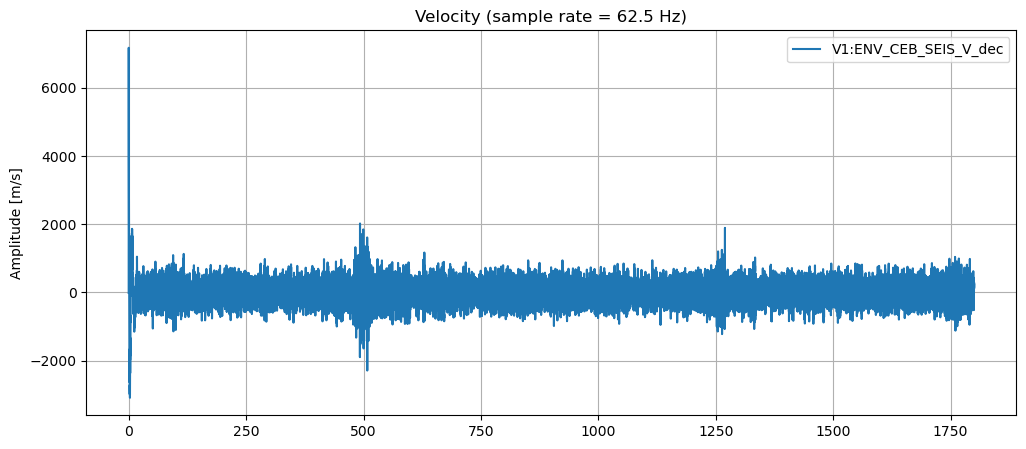

In [7]:
# Plotting the data
#time domain
plt.figure(figsize=(12, 5))
plt.plot(t,seism, label='V1:ENV_CEB_SEIS_V_dec')
plt.title('Velocity (sample rate = 62.5 Hz)')
plt.ylabel('Amplitude [m/s]')
plt.legend()
plt.grid()
plt.show()


In [ ]:
ftransform = np.fft.fft(seism)

#multiply the FT by 2 pi f
frequencies = np.fft.fftfreq(len(seism), d = 1/62.5)
    
X_f = np.zeros_like(ftransform, dtype=complex) #create an array of zeros with the same shape as V
nonzero = frequencies != 0 #boolean mask: true if freq is not zero
#for all non-zero frequencies, divide the FT by 2 pi f the take the IFT to get the displacement
X_f[nonzero] = ftransform[nonzero] / (1j * 2 * np.pi * frequencies[nonzero])
zt = np.fft.ifft(X_f)



#multiply the FT by 2 pi f then take the IFT to get the acceleration
acc = ftransform * (frequencies * 2 * np.pi * 1j)
At = np.fft.ifft(acc)


#calculate the PSDs to plot the velocity and acceleration spectra
fAcc, psdAcc = signal.welch(At.real, fs =62.5, window='hann', nperseg=nperseg)
fVel, psdVel = signal.welch(seism, fs =62.5, window='hann', nperseg=nperseg)
fZ, psdZ = signal.welch(zt.real, fs =62.5, window='hann', nperseg=nperseg)


0.0
[ 0.00055556  0.00111111  0.00166667 ... -0.00166667 -0.00111111
 -0.00055556]


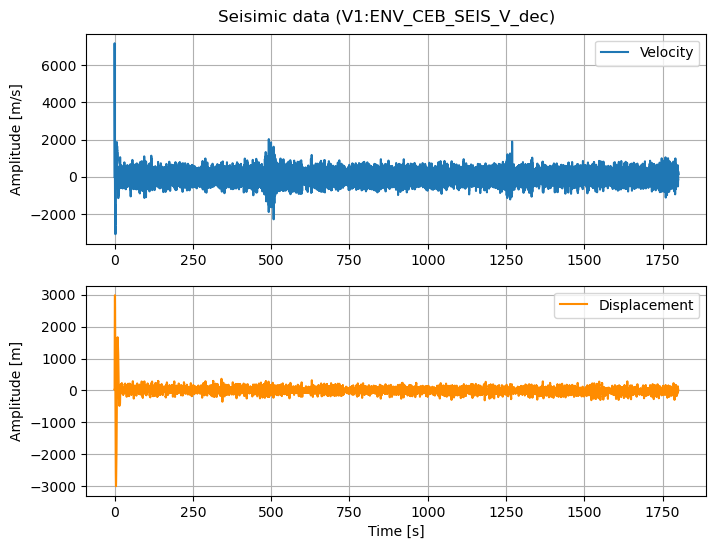

In [170]:
plt.figure(figsize=(8, 6))
plt.suptitle('Seisimic data (V1:ENV_CEB_SEIS_V_dec)', fontsize=12, y = 0.92)

plt.subplot(2, 1, 1)
plt.plot(t, seism, label='Velocity')
plt.ylabel('Amplitude [m/s]')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, zt.real, label='Displacement', color='darkorange')
plt.ylabel('Amplitude [m]')
plt.legend()
plt.grid()
plt.xlabel('Time [s]')
plt.show()

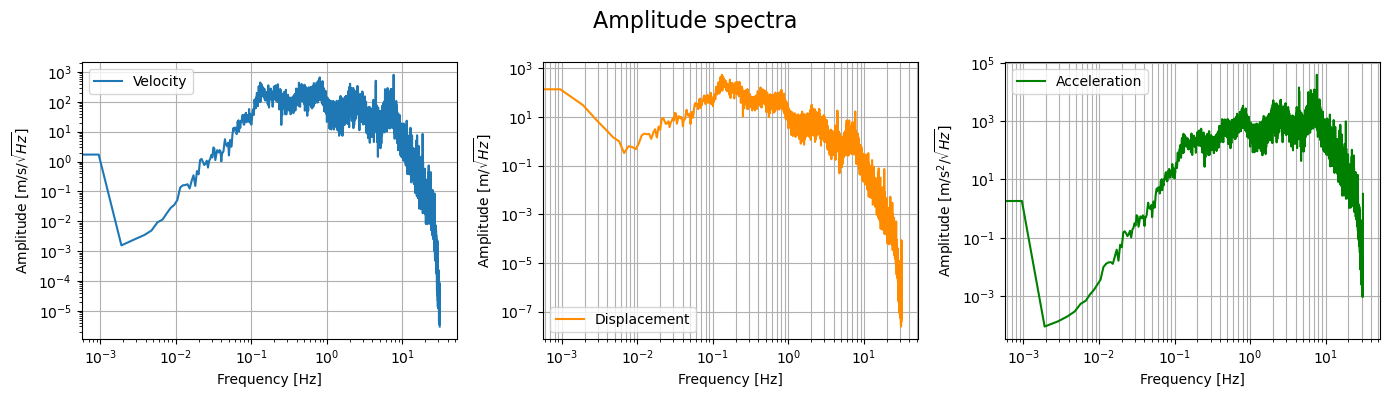

In [171]:
plt.figure(figsize=(14, 4))

plt.suptitle('Amplitude spectra', fontsize=16)

plt.subplot(1, 3, 1)
plt.loglog(fVel, np.sqrt(psdVel), label='Velocity')
plt.ylabel('Amplitude [m/s/$\sqrt{Hz}$]')
plt.xlabel('Frequency [Hz]')
plt.grid()
plt.legend()

plt.subplot(1, 3, 2)
plt.loglog(fZ, np.sqrt(psdZ), label='Displacement', color='darkorange')
plt.ylabel('Amplitude [m/$\sqrt{Hz}$]')
plt.xlabel('Frequency [Hz]')
plt.grid(which = 'both', axis = 'both')
plt.legend()

plt.subplot(1, 3, 3)
plt.loglog(fAcc, np.sqrt(psdAcc), label ='Acceleration', color='green')
plt.ylabel('Amplitude [m/s$^2$/$\sqrt{Hz}$]')
plt.xlabel('Frequency [Hz]')
plt.grid(which = 'both', axis = 'both')
plt.legend()
plt.tight_layout()
plt.show()

## Vertical control

In [172]:
def force_function(t, mass, acceleration):
    return mass * np.real(acceleration)*1e-6


In [174]:
def evolution(evol_method, Nt_step, dt, physical_params, signal_params,
              F, file_name = None):
    """
    Simulates the temporal evolution of the system under the influence of an
    external force.

    Parameters
    ----------
    evol_method : function
        The function used to evolve the system (e.g. Euler or ARMA methods).
    Nt_step : int
        The number of temporal steps to simulate.
    dt : float
        The time step size.
    physical_params : list
        The list of physical parameters for the system.
    signal_params : list
        The list of parameters for the external force signal.
    F : function
        The function modeling the external force.
    file_name : str, optional
        The name of the file to save simulation data. Default is None.

    Returns
    -------
    tuple
        A tuple containing the time grid and the arrays of velocities
        and positions for each mass.
    """
    # Initialize the problem
    tmax = Nt_step * dt  # maximum time
    tt = np.arange(0, tmax, dt)  # time grid
    
    y0 = np.array(
        (0, 0, 0, 0, 0, 0, 0., 0., 0., 0., 0., 0.))  # initial condition
    y_t = np.copy(y0)  # create a copy to evolve it in time
    F_signal = F(tt, *signal_params)  # external force applied over time (cambia)


    # Initialize lists for velocities and positions
    v1, v2, v3, v4, v5, v6 = [[], [], [], [], [], []]
    x1, x2, x3, x4, x5, x6 = [[], [], [], [], [], []]

    # compute the system matrices
    A, B = matrix(*physical_params)

    # time evolution when the ext force is applied
    i = 0
    for t in tt:
        Fi = F_signal[i]  # evaluate the force at time t
        i = i + 1
        y_t = evol_method(y_t, A, B, Fi)  # evolve to step n+1
        v1.append(y_t[0])
        v2.append(y_t[1])
        v3.append(y_t[2])
        v4.append(y_t[3])
        v5.append(y_t[4])
        v6.append(y_t[5])
        x1.append(y_t[6])
        x2.append(y_t[7])
        x3.append(y_t[8])
        x4.append(y_t[9])
        x5.append(y_t[10])
        x6.append(y_t[11])

    # save simulation's data (if a file name is provided)
    if file_name is not None:
        data = np.column_stack((tt, v1, v2, v3, v4, v5, v6,
                                x1, x2, x3, x4, x5, x6))
       # np.savetxt(os.path.join(data_dir, file_name), data,
        #           header='time, v1, v2, v3, v4, v5, v6, x1, x2, x3, x4, x5, x6')

    return (tt, np.array(v1), np.array(v2), np.array(v3), np.array(v4),
            np.array(v5), np.array(v6), np.array(x1), np.array(x2),
            np.array(x3), np.array(x4), np.array(x5), np.array(x6))



In [175]:
Nt_step = At.size  # temporal steps
dt = 1e-3

# Parameters of the system
gamma = [5, 5, 5, 5, 5]  # viscous friction coeff [kg/m*s]
M = [160, 125, 120, 110, 325, 82]  # filter mass [Kg]
K = [700, 1500, 3300, 1500, 3400, 564]  # spring constant [N/m]

F = force_function

#freq = np.loadtxt('freq.txt', unpack=True)
#freq = np.arange(1e-2,1e1,0.0003)
freq = np.linspace(1e-2, 1e1, 112500)
wn = 2*np.pi*freq

#print(freq[7]-freq[6])   #0.0030517578125 Hz
# Simulation 
physical_params = [*M, *K, *gamma, dt]
simulation_params = [AR_model, Nt_step, dt] 
signal_params = [M[0], At]  
#tt = np.linspace(0, Nt_step * dt, Nt_step, endpoint=False)

tt, v1, v2, v3, v4, v5, v6, x1, x2, x3, x4, x5, x6 = (
                        evolution(*simulation_params, physical_params, signal_params,
                        F, file_name = None))

Tf, poles = TransferFunc(wn, *M, *K, *gamma)
# Compute the magnitude of the transfer function
#(modulus squared) square rooted
H = (np.real(Tf) ** 2 + np.imag(Tf) ** 2) ** (1 / 2)


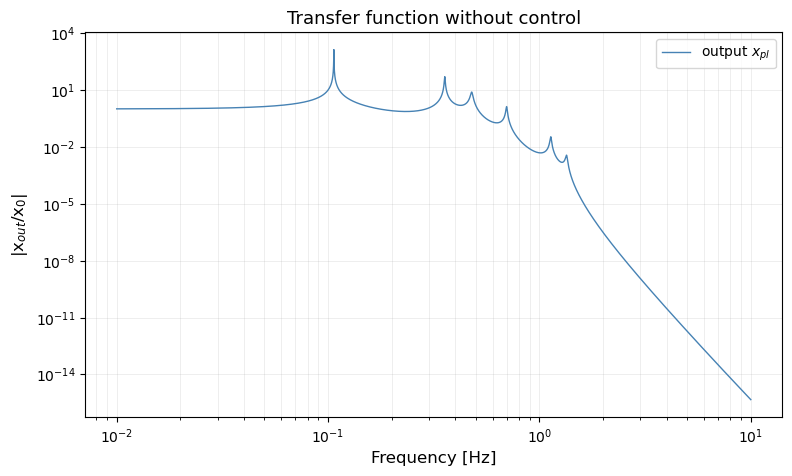

In [176]:
fig = plt.figure(figsize=(9, 5))
plt.title('Transfer function without control', size=13)
plt.xlabel('Frequency [Hz]', size=12)
plt.ylabel('|x$_{out}$/x$_0$|', size=12)
plt.yscale('log')
plt.xscale('log')
plt.grid(True, which='both', ls='-', alpha=0.3, lw=0.5)
plt.minorticks_on()

#plt.plot(freq, H[0], linestyle='-', linewidth=1, marker='', color='blue', label='output $x_1$')
plt.plot(freq, H[5], linestyle='-', linewidth=1, marker='', color='steelblue', label='output $x_{pl}$')
plt.legend()
plt.show()

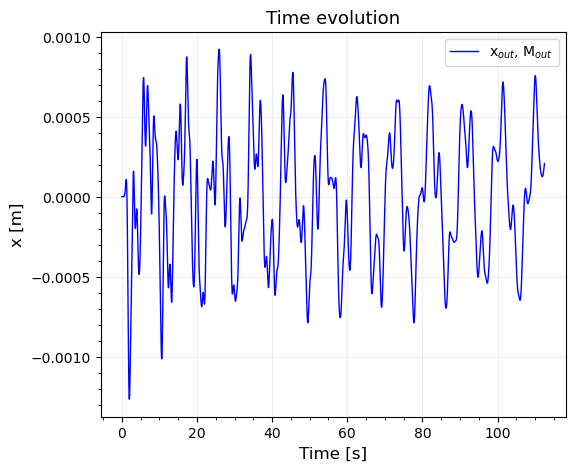

In [177]:
# ------------------------------Plot time evolution------------------------#
# # save time evol in a file (for the first and last mass)
# np.savetxt(os.path.join(data_dir, 'timeEvol_noControl.txt'),
#             np.column_stack((tt, x1, x6)), header='time[s], x1, x6')

fig = plt.figure(figsize=(6, 5))
plt.title('Time evolution', size=13)
plt.xlabel('Time [s]', size=12)
plt.ylabel('x [m]', size=12)
plt.grid(True, ls='-', alpha=0.3, lw=0.5)
plt.minorticks_on()

#plt.plot(tt, x1, linestyle='-', linewidth=1, marker='', color='steelblue', label='x1, M$_1$')
#plt.plot(tt, x2, linestyle='-', linewidth=1, marker='', color='black', label='x2, M$_2$')
#plt.plot(tt, x3, linestyle='-', linewidth=1, marker='', color='red', label='x3, M$_3$')
#plt.plot(tt, x4, linestyle='-', linewidth=1, marker='', color='green', label='x4, M$_4$')
#plt.plot(tt, x5, linestyle='-', linewidth=1, marker='', color='darkmagenta', label='x7, M$_7$')
plt.plot(tt, x6, linestyle='-', linewidth=1, marker='',color='blue', label='x$_{out}$, M$_{out}$') #ultima massa
plt.legend()
plt.show()



In [ ]:
xf_in = np.fft.fft(zt)



In [226]:
x_out_freq_domain = np.fft.fft(x6)

v_out_freq_domain = np.fft.fft(v6)

In [229]:
trfn = x_out_freq_domain/xf_in
Hfn = (np.real(trfn) ** 2 + np.imag(trfn) ** 2) ** (1 / 2)

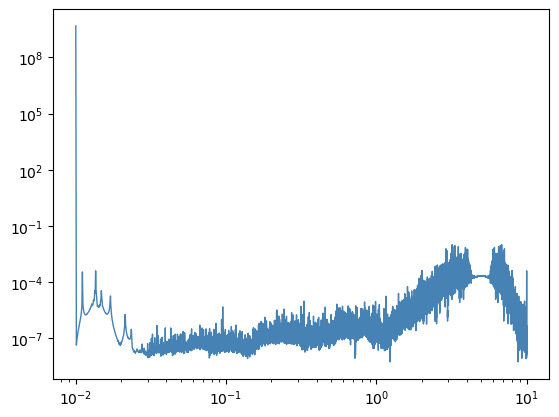

In [230]:
plt.loglog(freq, Hfn, linestyle='-', linewidth=1, marker='', color='steelblue', label='output $x_{pl}$')


In [196]:
output = H[5][1:]*X_f[nonzero]

In [203]:
#xt_out = np.fft.ifft(xf_out)
xt_out = np.fft.ifft(output)*1e-6

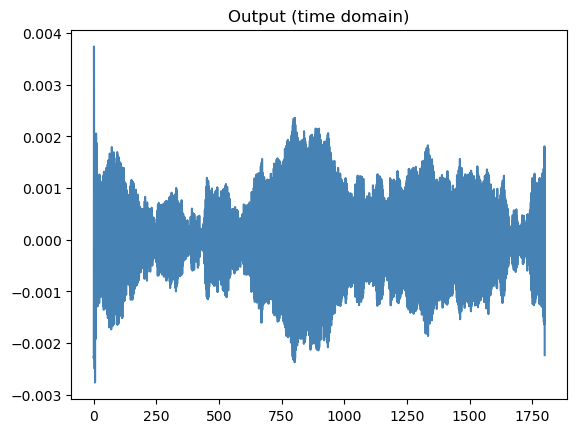

In [205]:
#plt.scatter(freq, xf_out.real, s = 0.1)
#plt.plot(tt, np.real(xt_out), color='steelblue', label='output $x_{pl}$')
plt.plot(np.linspace(0,T,len(xt_out)), np.real(xt_out), color='steelblue', label='output $x_{pl}$')
plt.title('Output (time domain)')
# plt.yscale('log')
# plt.xscale('log')
plt.show()

In [159]:
#compute acceleration from output v6
v6_FT = np.fft.fft(v6)
v6_freq = np.fft.fftfreq(len(v6), d = 1/62.5)

acc_out =  v6_FT * (v6_freq * 2 * np.pi * 1j) #acceleration nel dominio delle frequenze

A_out = np.fft.ifft(acc_out) #time domain

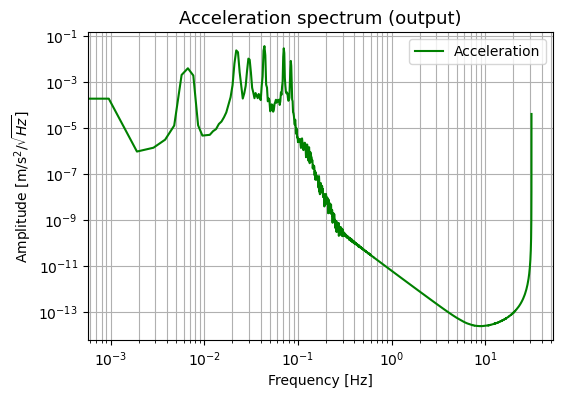

In [160]:
#generate ASD
fAcc_out, psdAcc_out = signal.welch(A_out.real, fs =62.5, window='hann', nperseg=nperseg)
plt.figure(figsize=(6, 4))
plt.title('Acceleration spectrum (output)', fontsize=13)
plt.loglog(fAcc_out, np.sqrt(psdAcc_out), label ='Acceleration', color='green')
plt.ylabel('Amplitude [m/s$^2$/$\sqrt{Hz}$]')
plt.xlabel('Frequency [Hz]')
plt.grid(which = 'both', axis = 'both')
plt.legend()
plt.show()


In [132]:
f_x6_out, psd_x6_out = signal.welch(x6, fs =62.5, window='hann', nperseg=nperseg)

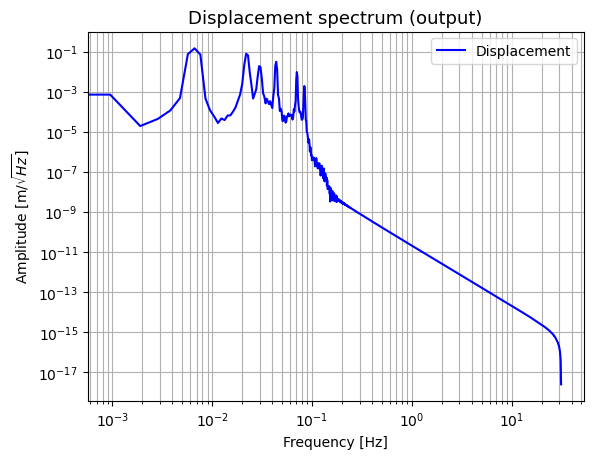

In [133]:
plt.loglog(f_x6_out, np.sqrt(psd_x6_out), label ='Displacement', color='blue')
plt.ylabel('Amplitude [m/$\sqrt{Hz}$]')
plt.xlabel('Frequency [Hz]')
plt.grid(which = 'both', axis = 'both')
plt.title('Displacement spectrum (output)', fontsize=13)
plt.legend()
plt.show()